### Test - Synthetic Diagnostic + Interferometry

</b> Author:   </b>  Louis Evans     </br>
</b> Reviewer: </b>  Stefano Merlini

### Import relevant files:

In [222]:
import numpy as np
import vtk
from vtk.util import numpy_support as vtk_np
import matplotlib.pyplot as plt
import gc

import sys

#add path
sys.path.insert(0, '../../synthPy_restructured')     # import path/to/synthpy

import beam as beam_initialiser
import diagnostics as diag
import domain as d
import propagator as p
import utils

import importlib
importlib.reload(beam_initialiser)
importlib.reload(diag)
importlib.reload(d)
importlib.reload(p)
importlib.reload(utils)

<module 'utils' from 'c:\\Users\\qinal\\OneDrive - Imperial College London\\UROP\\synthPy\\examples\\notebooks\\../../synthPy_restructured\\utils.py'>

To use the ray tracer, first create a 'domain', load the domain with an electron distribution, calculate electron gradients, initialise a beam, and solve!
\
\
The output can either be plotted, or passed further through ray optics for synthetic diagnostics

In [223]:
# define some extent, the domain should be distributed as +extent to -extent, does not need to be cubic
extent_x = 5e-3
extent_y = 5e-3
extent_z = 10e-3

n_cells = 100

#x = np.linspace(-extent_x, extent_x, n_cells)
#y = np.linspace(-extent_y, extent_y, n_cells)
#z = np.linspace(-extent_z, extent_z, n_cells)

probing_extent = extent_z
probing_direction = 'z'

lengths = 2 * np.array([extent_x, extent_y, extent_z])

print("Garbage collection count:", gc.collect())

#domain = d.ScalarDomain(x = x, y = y, z = z, extent= probing_extent, probing_direction = probing_direction)     # create domain
# Much simpler domain function, no longer needlessly takes in beam values, they are fully seperated
domain = d.ScalarDomain(lengths, n_cells) # B_on = False by default

# clear we should do manual garbage collection of some variety in d.ScalarDomain function
print("Garbage collection count:", gc.collect())

Garbage collection count: 10666
Garbage collection count: 0


Load some domain distribution

In [224]:
# load some external pvti
# import utils.handle_filetypes as load
# ne, dim, spacing = load.pvti_readin(filename)
# or load a test distribution

#domain.ne = np.full((100, 100, 100), 1e24)
domain.test_exponential_cos()
#domain.test_slab(0.000001, 1e24)
domain.external_Te(np.full((n_cells, n_cells, n_cells), 2e5))
domain.external_mass_density(np.full((n_cells, n_cells, n_cells), 2e3))

Solve gradients, initialise beam, and solve

In [225]:
wl = 1064e-9 #define laser wavelength

# initialise beam
Np = 10000  # number of photons
divergence = 5e-5   # realistic divergence value
beam_size = extent_x    # beam radius
ne_extent = probing_extent  # so the beam knows where to initialise initial positions
beam_type = 'circular'

initial_rays = beam_initialiser.Beam(Np, beam_size, divergence, ne_extent, probing_direction, wl, beam_type)

tracer = p.Propagator(domain, initial_rays, inv_brems = True, x_ray = False, phaseshift = False)
# solve ray trace
tracer.calc_dndr()
tracer.set_up_interps()
final_rays = tracer.solve(parallelise = False, jitted = True, Nt = 100)
times = tracer.t
positions = tracer.Beam.positions
amplitudes = tracer.Beam.amplitudes



#final_rays, final_rays_to_Jonesvector = tracer.Beam.rf, tracer.Beam.Jf
print("\nCompleted ray trace in", np.round(tracer.duration, 3), "seconds.")

[[ 0.0014838   0.00148364  0.00148317 ...  0.00075661  0.00074537
   0.00073413]
 [-0.00169845 -0.00169847 -0.00169851 ... -0.00175003 -0.00175084
  -0.00175164]
 [ 0.00386606  0.0038659   0.00386543 ...  0.00292718  0.00291296
   0.00289874]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
(90000, 100)

Completed ray trace in 27.309 seconds.


(10000, 100, 3)
[[ 1.24952385e-03  4.41780604e-03 -1.00000000e-02]
 [ 1.24949984e-03  4.41805801e-03 -9.71430030e-03]
 [ 1.24944297e-03  4.41880031e-03 -9.42860060e-03]
 [ 1.24935356e-03  4.42002848e-03 -9.14290090e-03]
 [ 1.24923214e-03  4.42173517e-03 -8.85720120e-03]
 [ 1.24907945e-03  4.42391015e-03 -8.57150150e-03]
 [ 1.24889640e-03  4.42654040e-03 -8.28580180e-03]
 [ 1.24868413e-03  4.42961019e-03 -8.00010210e-03]
 [ 1.24844396e-03  4.43310114e-03 -7.71440240e-03]
 [ 1.24817737e-03  4.43699239e-03 -7.42870270e-03]
 [ 1.24788602e-03  4.44126068e-03 -7.14300300e-03]
 [ 1.24757175e-03  4.44588054e-03 -6.85730330e-03]
 [ 1.24723651e-03  4.45082437e-03 -6.57160360e-03]
 [ 1.24688243e-03  4.45606273e-03 -6.28590390e-03]
 [ 1.24651173e-03  4.46156439e-03 -6.00020420e-03]
 [ 1.24612675e-03  4.46729657e-03 -5.71450450e-03]
 [ 1.24572994e-03  4.47322520e-03 -5.42880480e-03]
 [ 1.24532381e-03  4.47931505e-03 -5.14310510e-03]
 [ 1.24491095e-03  4.48552993e-03 -4.85740540e-03]
 [ 1.24449400e-

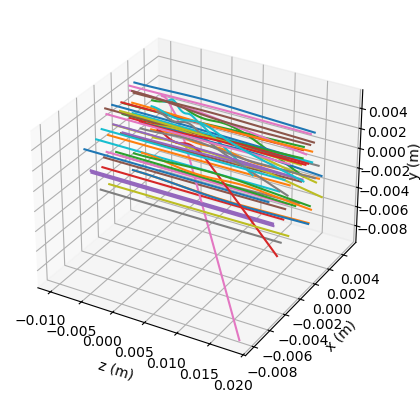

In [226]:
print(positions.shape)
axes = plt.axes(projection = "3d")
num_rays = 50
subset_rays = positions[np.random.randint(low = Np, size = num_rays)]
for i in subset_rays:
    print(i)
    x, y, z = zip(*i)
    plt.plot(z, x, y)
axes.set_xlabel('z (m)')
axes.set_ylabel('x (m)')
axes.set_zlabel('y (m)')
plt.show()

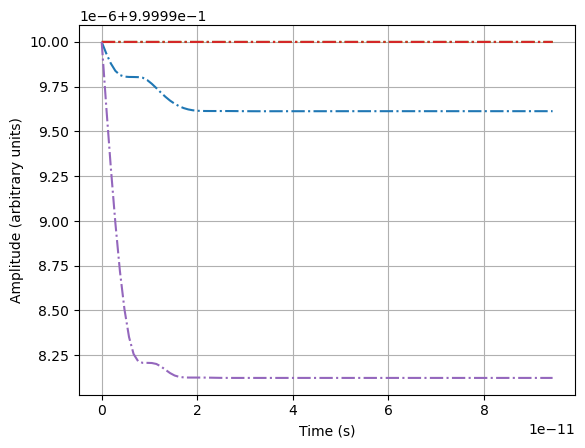

In [235]:
num_rays = 5
subset_rays = amplitudes[np.random.randint(low = Np, size=num_rays)]
for i in subset_rays:
    plt.plot(times, i, "-.")
plt.grid()
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (arbitrary units)")
plt.show()


r0 after clearing nan's: (10000, 10000)


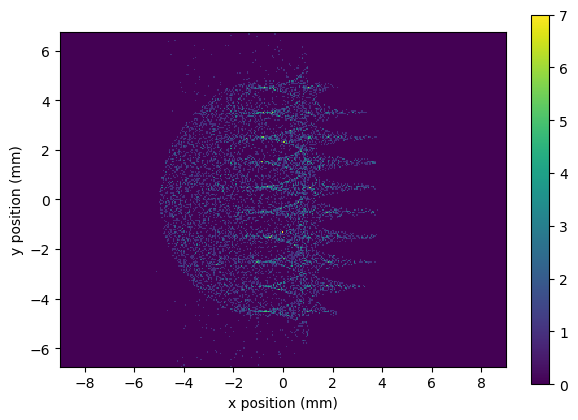

In [228]:
fig, ax = plt.subplots()
tracer.Beam.rf = tracer.Beam.rf*1e3
diagnostic=diag.Diagnostic(tracer.Beam)
diagnostic.histogram(bin_scale=10, clear_mem=True)
diagnostic.plot(ax)
tracer.Beam.rf = tracer.Beam.rf*1e-3

Pass through ray optics: For Shadowgaphy, Schlieren, or Refractometry:


r0 after clearing nan's: (7893, 7893)
Garbage collection count: 16264


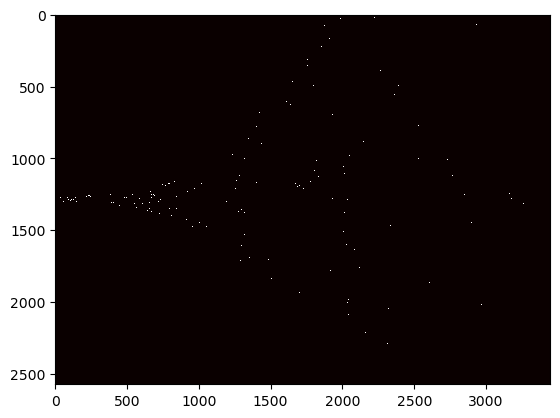

In [229]:
#in the diagnostic initialisation, details on the lens configurations, and detector dimensions can be specified
refractometer = diag.Refractometry(tracer.Beam)
refractometer.incoherent_solve()
# cam't clear_mem if you want to generate other graphs afterwards
refractometer.histogram(bin_scale = 1, clear_mem = False)

#information accessed by .H(istogram) , e.g plt.imshow(refractometer.H)

#plt.imshow(refractometer.H, cmap='hot', interpolation='nearest', clim = (0, 2))
plt.imshow(refractometer.H, cmap = 'hot', interpolation = 'nearest', clim = (0.5, 1))

print("Garbage collection count:", gc.collect())


r0 after clearing nan's: (7893, 7893)
Garbage collection count: 3050


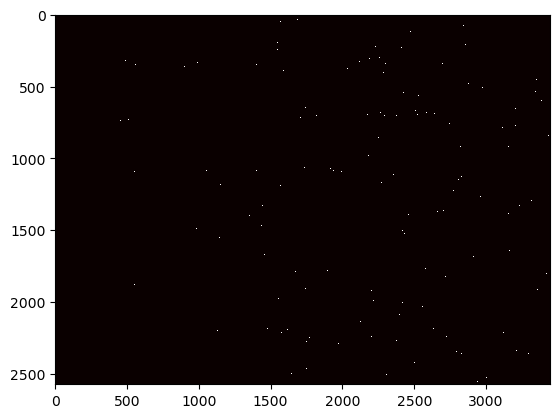

In [230]:
shadowgrapher = diag.Shadowgraphy(tracer.Beam)
shadowgrapher.single_lens_solve()
shadowgrapher.histogram(bin_scale = 1, clear_mem = False)

plt.imshow(shadowgrapher.H, cmap = 'hot', interpolation = 'nearest', clim = (0.5, 1))

print("Garbage collection count:", gc.collect())

[[            nan  1.72827762e+00 -3.31105604e+00 ... -7.35997689e-01
              nan             nan]
 [            nan  2.82046819e-03  4.97295077e-02 ...  3.36047481e-02
              nan             nan]
 [            nan -1.84686692e+00 -1.43361530e+00 ...  1.20450412e-01
              nan             nan]
 [            nan  5.42331323e-03 -3.94379263e-03 ... -7.84550969e-04
              nan             nan]]

r0 after clearing nan's: (4893, 4893)
Garbage collection count: 3050


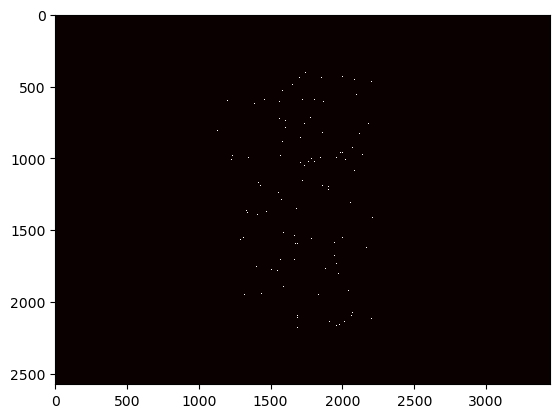

In [231]:
schlierener = diag.Schlieren(tracer.Beam)
schlierener.DF_solve()
schlierener.histogram(bin_scale = 1, clear_mem = True)

plt.imshow(schlierener.H, cmap = 'hot', interpolation = 'nearest', clim = (0.5, 1))

print("Garbage collection count:", gc.collect())

Synthetic Interferometry - This requires some extra steps in the ray tracing to include information on the phase and electric field values

In [232]:
# No need to change the domain (now that code has been seperated out in restructure)



# load some external pvti

# import utils.handle_filetypes as load
# ne, dim, spacing = load.pvti_readin(filename)

# or load a test distribution



# initialise beam


# solve ray trace
tracer = p.Propagator(domain, initial_rays, inv_brems = False, phaseshift = False, x_ray = False)

tracer.calc_dndr()
tracer.set_up_interps()
tracer.Beam.rf, tracer.Beam.Jf = tracer.solve(parallelise = False, jitted = False, return_E = True)

n_fringes = 10
deg = 10 #adjust number of fringes and tilt in degrees from the vertical exis
print('hi')
interferometrer = diag.Interferometry(tracer.Beam)
interferometrer.interfere_ref_beam(n_fringes, deg)

pattern = diag.Interferometry(tracer.Beam)
#pattern = interferometrer
pattern.two_lens_solve()
pattern.interferogram(bin_scale = 1, clear_mem = True) #use interferogram instead of histogram

#get interferogram histogram with sh.H


[[ 0.0014838   0.00073413]
 [-0.00169845 -0.00175164]
 [ 0.00386606  0.00289874]
 ...
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]]
(90000, 2)
hi


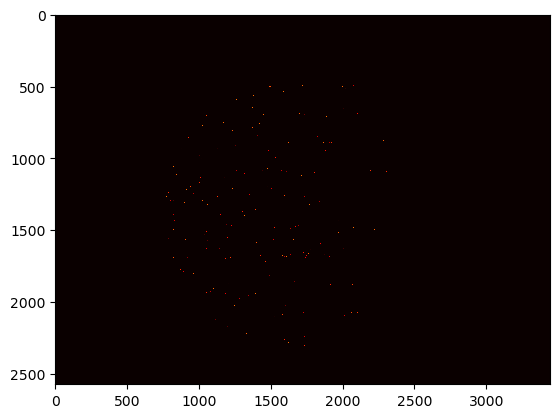

In [233]:
plt.imshow(pattern.H, cmap = 'hot', interpolation = 'nearest')